In [1]:
import json
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from joblib import Parallel, delayed
import os
import multiprocessing
import seaborn as sns
import numpy as np


In [2]:

# Carregar dados JSON
with open('./MC3/mc3.json', 'r') as f:
    data = json.load(f)

In [3]:

# Converter dados para DataFrames
df_nodos = pd.DataFrame(data['nodes'])
df_links = pd.DataFrame(data['links'])

In [4]:
df_nodos[df_nodos['id'] == 'Acosta-Flores']

,type,country,ProductServices,PointOfContact,HeadOfOrg,founding_date,revenue,TradeDescription,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,id,dob
14,Entity.Organization.FishingCompany,Mawalara,Fish and seafood products,Katrina Martinez,Alessio Romiti,1961-01-03T00:00:00,24766.67,Acosta-Flores is a leading provider of fresh a...,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,Acosta-Flores,NaN


In [5]:
# Filtrar links de propriedade
#df_links_propriedade = df_links[df_links['type'] == 'Event.Owns.Shareholdership']

In [6]:
#df_links_propriedade[df_links_propriedade['source'] == 'Acosta-Flores']

In [106]:
# Criar grafo
G = nx.from_pandas_edgelist(df_links, 'source', 'target', edge_attr=True)

In [8]:
#missing_nodes = set(df_nodos['id']) - set(G.nodes)
#if missing_nodes:
#    print(f"IDs de nodos ausentes no grafo: {missing_nodes}")

In [108]:
# Adicionar atributos aos nodos
for index, row in df_nodos.iterrows():
    if row['id'] in G.nodes:
        G.nodes[row['id']].update(row.to_dict())

In [10]:
# Visualização inicial do grafo
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
#plt.show()

In [11]:
# Função para calcular o layout em paralelo
def calculate_layout_parallel(graph, num_chunks):
    nodes = list(graph.nodes())
    chunks = [nodes[i::num_chunks] for i in range(num_chunks)]
    
    def spring_layout_chunk(chunk):
        subgraph = graph.subgraph(chunk)
        return nx.spring_layout(subgraph)
    
    layout_parts = Parallel(n_jobs=num_chunks)(
        delayed(spring_layout_chunk)(chunk) for chunk in chunks
    )
    
    pos = {}
    for part in layout_parts:
        pos.update(part)
    
    return pos

In [12]:
num_cores = multiprocessing.cpu_count()
num_cores = int(num_cores * 0.8)

In [ ]:
# Calcular o layout usando processamento paralelo
#pos = calculate_layout_parallel(G, num_cores)


In [14]:
# Desenhar o grafo
#nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
#plt.show()

In [15]:
southseafood_node = df_nodos[df_nodos['id'] == 'SouthSeafood Express Corp']
southseafood_node

,type,country,ProductServices,PointOfContact,HeadOfOrg,founding_date,revenue,TradeDescription,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,id,dob
60463,Entity.Organization.FishingCompany,Oceanus,Fishing and other related activities,Luce du Adam,Achille Forza,2032-11-05T00:00:00,6529.36,Offering comprehensive fishing solutions and r...,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,SouthSeafood Express Corp,NaN


In [16]:
southseafood_events = df_links[(df_links['source'] == 'SouthSeafood Express Corp') | (df_links['target'] == 'SouthSeafood Express Corp')]
southseafood_events

,start_date,type,_last_edited_by,_last_edited_date,_date_added,_raw_source,_algorithm,source,target,key,end_date
75663,2033-10-29T00:00:00,Event.Owns.Shareholdership,Pelagia Alethea Mordoch,2035-01-01T00:00:00,2035-01-01T00:00:00,Existing Corporate Structure Data,Automatic Import,AguaLeska Transit N.V.,SouthSeafood Express Corp,0,2035-05-25T00:00:00
75699,2035-05-25T00:00:00,Event.Owns.Shareholdership,Niklaus Oberon,2035-06-15T00:00:00,2035-06-15T00:00:00,Oceanus Corporations Monthly - May '35,Manual Entry,Tainamarine Fishing Co,SouthSeafood Express Corp,0,NaN


Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

In [17]:
df_links['type'].unique()

array(['Event.Owns.Shareholdership', 'Event.Owns.BeneficialOwnership',
       'Event.WorksFor', 'Relationship.FamilyRelationship'], dtype=object)

In [18]:
# Adicionar coluna de ano para facilitar a análise temporal
def convert_to_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%Y-%m-%d").date()
    except ValueError:
        return pd.to_datetime(date_str).date()
    
df_links['start_date'] = df_links['start_date'].apply(convert_to_date)
df_links['year'] = pd.to_datetime(df_links['start_date']).dt.year


# Contagem de relações por ano
relations_per_year = df_links.groupby(['year', 'type']).size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.bar(relations_per_year, x='year', y='counts', color='type', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.show()

Exemplos de Transações Comerciais Típicas e Atípicas
Para identificar e visualizar transações típicas e atípicas, vamos criar gráficos que mostrem a distribuição dos tipos de transações:

In [19]:
# Exemplo de transações típicas e atípicas
transaction_counts = df_links['type'].value_counts().reset_index()
transaction_counts.columns = ['TransactionType', 'Counts']

# Gráfico de pizza para mostrar a distribuição dos tipos de transações
fig = px.pie(transaction_counts, values='Counts', names='TransactionType', title='Distribuição dos Tipos de Transações')
fig.show()


Inferências de Influência ao Longo do Tempo
Para inferir a influência de uma empresa ao longo do tempo, utilizaremos métricas de centralidade:

In [20]:
# Calcular centralidade ao longo do tempo
centrality = nx.degree_centrality(G)

# Converter para DataFrame para visualização
df_centrality = pd.DataFrame.from_dict(centrality, orient='index', columns=['Centrality'])
df_centrality.reset_index(inplace=True)
df_centrality.columns = ['Node', 'Centrality']

# Visualização da centralidade
fig = px.histogram(df_centrality, x='Centrality', title='Distribuição da Centralidade das Empresas')
fig.show()


Rede Associada à SouthSeafood Express Corp e Impactos
Identificar a rede associada à SouthSeafood Express Corp e visualizar mudanças após o comportamento ilegal:

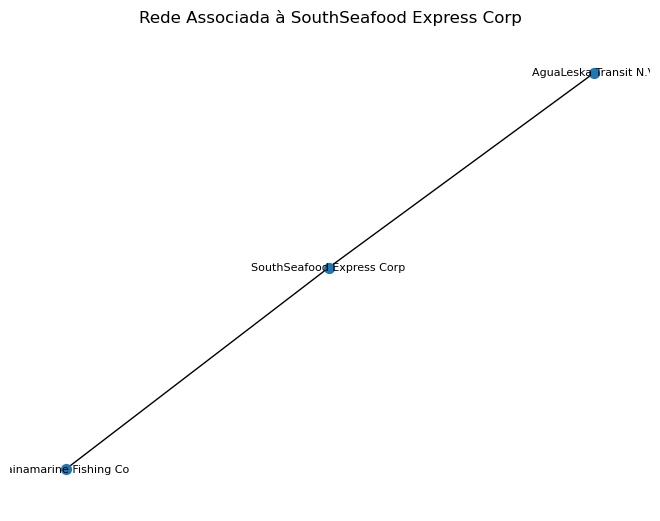

In [21]:
# Filtrar as arestas e nós relacionados à SouthSeafood Express Corp
ssc_network = df_links[(df_links['source'] == 'SouthSeafood Express Corp') | (df_links['target'] == 'SouthSeafood Express Corp')]

# Criar subgrafo
ssc_subgraph = G.subgraph(ssc_network['source'].tolist() + ssc_network['target'].tolist())

# Visualização do subgrafo
pos = nx.kamada_kawai_layout(ssc_subgraph)
nx.draw(ssc_subgraph, pos, with_labels=True, node_size=50, font_size=8)
plt.title('Rede Associada à SouthSeafood Express Corp')
plt.show()


#refazendo primeiro item    

Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

In [22]:
df_links_property = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficial = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

In [23]:
# Criar um grafo direcionado para relações de propriedade
G_property = nx.DiGraph()
for _, row in df_links_property.iterrows():
    G_property.add_edge(row['source'], row['target'], start_date=row['start_date'], end_date=row['end_date'])

# Criar um grafo direcionado para relações de benefício econômico
G_beneficial = nx.DiGraph()
for _, row in df_links_beneficial.iterrows():
    G_beneficial.add_edge(row['source'], row['target'], start_date=row['start_date'], end_date=row['end_date'])


In [24]:
df_links_property = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficial = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

In [25]:
# Função para plotar grafo com base nas datas
def plot_temporal_graph(G, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)
    for u, v, data in edges:
        plt.plot([data['start_date'], data['end_date']], [pos[u][1], pos[v][1]], linewidth=2, alpha=0.7)
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(title)
    plt.xlabel('Tempo')
    plt.ylabel('Empresas')
    plt.grid(True)
    plt.show()

# Plotar evolução temporal das relações de propriedade
#plot_temporal_graph(G_property, 'Evolução Temporal das Relações de Propriedade')


C:\Users\maico\AppData\Local\Temp\ipykernel_45004\1844283938.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maico\AppData\Local\Temp\ipykernel_45004\1844283938.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maico\AppData\Local\Temp\ipykernel_45004\1844283938.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

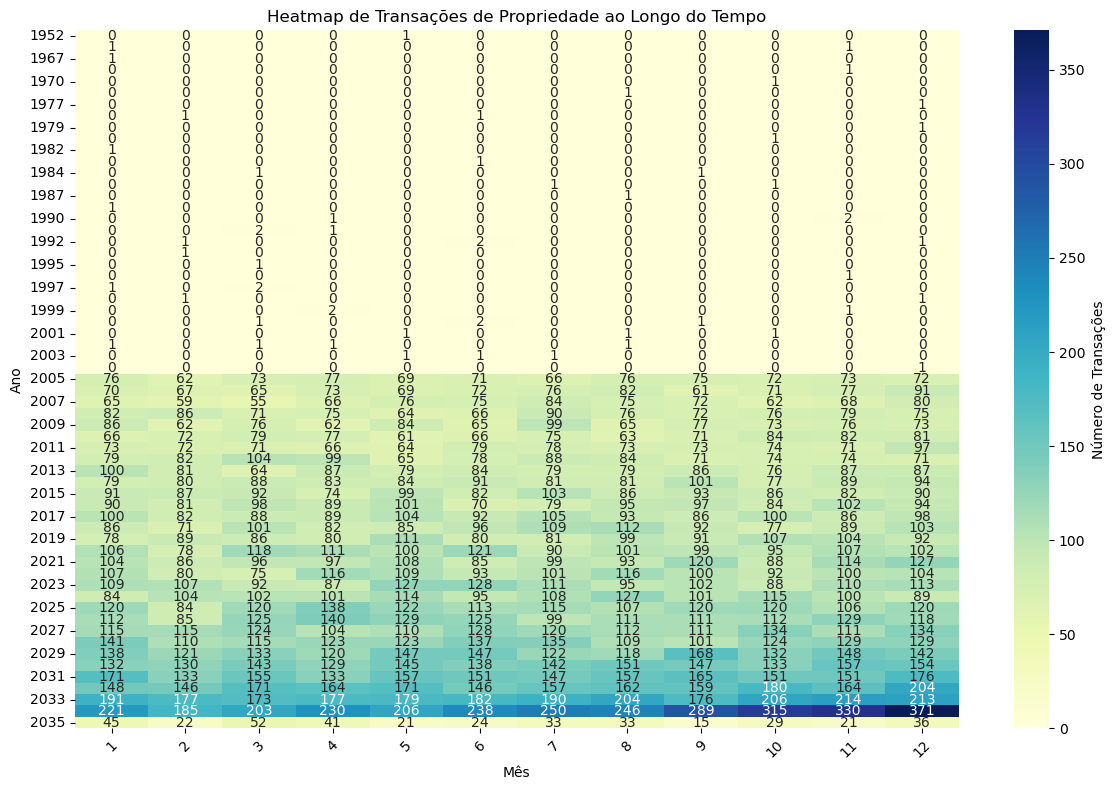

In [26]:
# Converter coluna de data para tipo datetime
df_links_property['start_date'] = pd.to_datetime(df_links_property['start_date'])

# Agrupar por ano e contar o número de transações de propriedade
df_links_property['year'] = df_links_property['start_date'].dt.year
df_links_property['month'] = df_links_property['start_date'].dt.month

heatmap_data = df_links_property.groupby(['year', 'month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g', cbar_kws={'label': 'Número de Transações'})
plt.title('Heatmap de Transações de Propriedade ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Ano')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [27]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_targets(df):
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df):
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership = count_unique_targets(df_links_shareholdership)
count_beneficialownership = count_unique_targets(df_links_beneficialownership)
count_works = count_unique_sources(df_links_worksfor)
count_familyrelationship = count_unique_targets(df_links_familyrelationship)

In [28]:
max_shareholder_year = count_shareholdership.groupby('start_date')['count'].max().reset_index()
max_beneficialownership_year = count_beneficialownership.groupby('start_date')['count'].max().reset_index()
max_count_worksfor_year = count_works.groupby('start_date')['count'].max().reset_index()

,source,start_date,count
0,Braydon Mccarthy,2028.0,1


In [ ]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_targets(df):
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df):
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership = count_unique_targets(df_links_shareholdership)
count_beneficialownership = count_unique_targets(df_links_beneficialownership)
count_works = count_unique_sources(df_links_worksfor)
count_familyrelationship = count_unique_targets(df_links_familyrelationship)

# Ownership

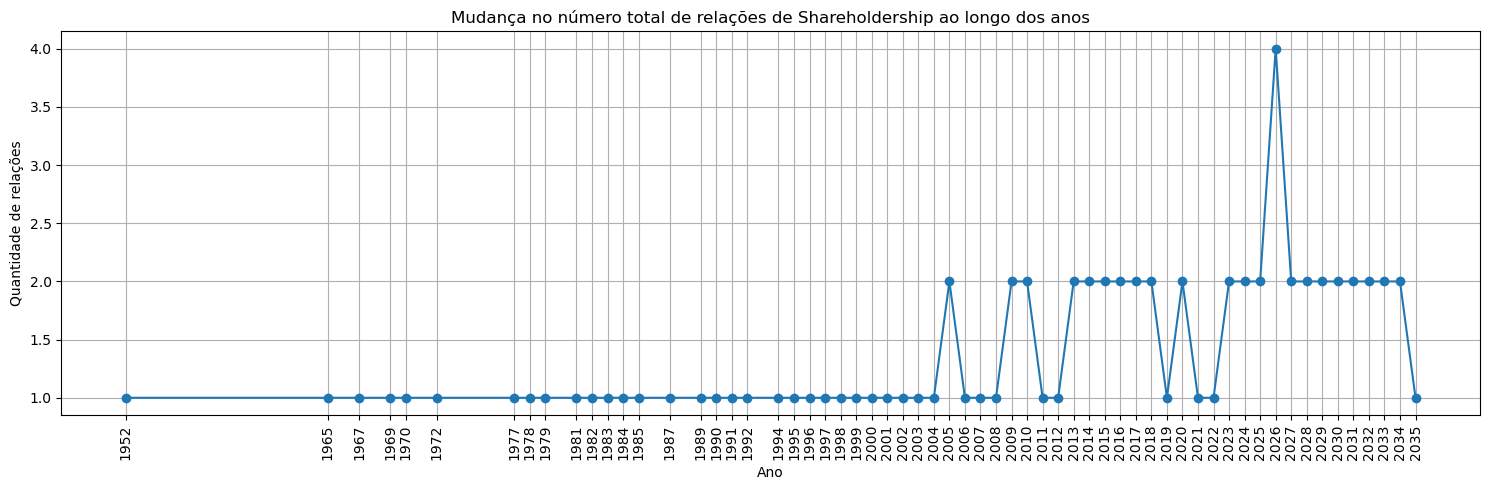

In [73]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_shareholder_year['start_date'], max_shareholder_year['count'], marker='o')
plt.title('Mudança no número total de relações de Shareholdership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_shareholder_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
df = count_shareholdership[count_shareholdership['count'] > 1].groupby(['count', 'start_date']).size().reset_index(name='num_companies').sort_values(by='start_date')


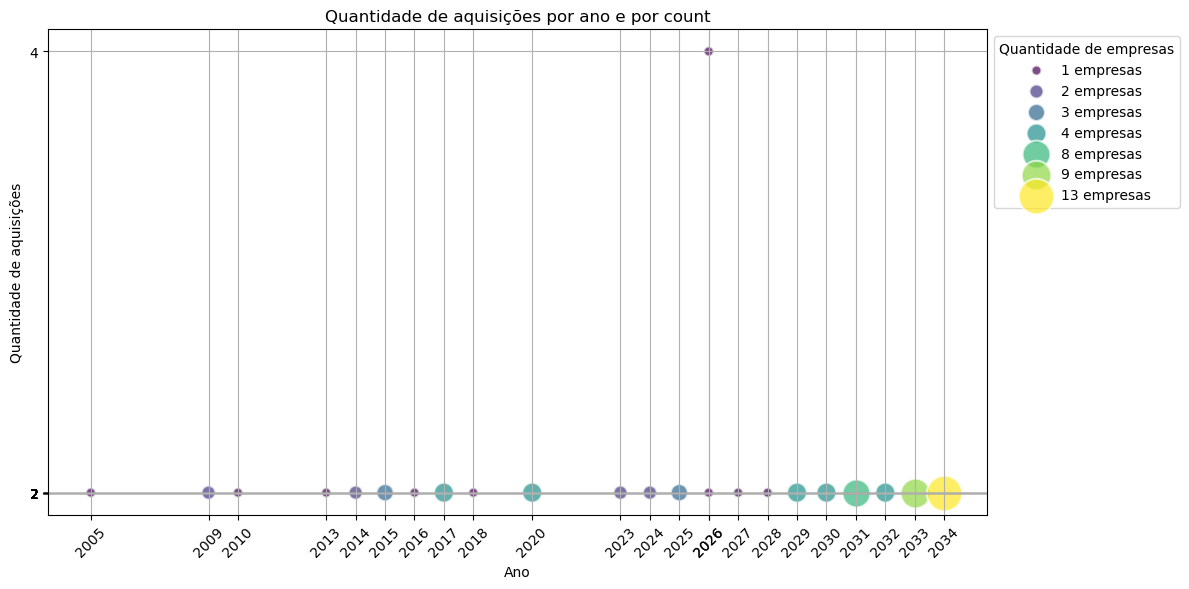

In [75]:

# Determinando as cores com base na quantidade de empresas (num_companies)
num_companies_unique = sorted(df['num_companies'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(num_companies_unique)))

# Mapeando as cores para cada valor único de num_companies
color_map = {num_companies: colors[i] for i, num_companies in enumerate(num_companies_unique)}

# Convertendo num_companies para cores correspondentes
df['color'] = df['num_companies'].map(color_map)

# Preparando o gráfico de dispersão
plt.figure(figsize=(12, 6))
for i, num_companies in enumerate(num_companies_unique):
    df_filtered = df[df['num_companies'] == num_companies]
    plt.scatter(df_filtered['start_date'], df_filtered['count'], s=df_filtered['num_companies']*50, c=[color_map[num_companies]], label=f'{num_companies} empresas', alpha=0.7, edgecolors='w', linewidth=1.5)

# Adicionando título e rótulos dos eixos
plt.title('Quantidade de aquisições por ano e por count')
plt.xlabel('Ano')
plt.ylabel('Quantidade de aquisições')

# Adicionando a legenda
plt.legend(title='Quantidade de empresas', loc='upper left', bbox_to_anchor=(1, 1))

# Configurando os ticks para mostrar todos os valores
plt.xticks(df['start_date'], rotation=45)
plt.yticks(df['count'])

plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
lista_proprietarios = count_shareholdership[(count_shareholdership['count'] > 1)  & (count_shareholdership['start_date'] == 2034)]['source']
df_nodos[df_nodos['id'].isin(lista_proprietarios)][['id', 'type']]

,id,type
3028,Hamilton-Park,Entity.Organization.Company
23506,Xavier Guillaume,Entity.Person.CEO
26452,David Copeland,Entity.Person
30923,Paige Palmer,Entity.Person
30957,Peter Hunter,Entity.Person
33345,Phillip Rogers,Entity.Person
35279,Amber Gonzales,Entity.Person
36863,Dr. Kimberly Camacho,Entity.Person
38648,Gwendolyn Phillips,Entity.Person
39687,Luke Hampton,Entity.Person


In [118]:
lista_aquisicoes = df_links_shareholdership[(df_links_shareholdership['source'].isin(lista_proprietarios)) & (df_links_shareholdership['year'] == 2034)][['source', 'target']]
filtered_nodos = df_nodos[df_nodos['id'].isin(lista_aquisicoes['target'])][['id', 'type']]
merged_df = lista_aquisicoes.merge(filtered_nodos, left_on='target', right_on='id', how='inner')
merged_df = merged_df[['source', 'target', 'type']]
merged_df

0                      Carlson-Wang
1                  Johnson-Gonzalez
2                       Harding LLC
3                       Morse Group
4     Barrett, Morales and Gonzalez
5                        Cortez LLC
6                        Cook-Terry
7                         Wade-Lynn
8                        Cooper Inc
9      Patrick, Mcneil and Williams
10                 Espinoza-Jackson
11                     Mcdaniel PLC
12     Garrett, Williams and Willis
13       Harper, Brennan and Taylor
14                   Gutierrez-Bell
15                       Liu-Dawson
16     Herrera, Smith and Gallagher
17                     Levy-Stanley
18                      Huffman Ltd
19      Stevens, Hoffman and French
20                      Perez-Munoz
21      Thomas, Richardson and Wade
22         Schmidt, Evans and Chase
23                    Taylor-Miller
24                        Scott Inc
25                      Terry-Allen
Name: target, dtype: object

In [77]:
count_shareholdership[(count_shareholdership['count'] == 4)]['source']

30615    Raymond LLC
Name: source, dtype: object

In [102]:
#df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC')  & (df_links_shareholdership['year'] == 2026)]['target']

filtered_links = df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC') & (df_links_shareholdership['year'] == 2026)]['target']

# Filtrando df_nodos usando os nós filtrados
filtered_nodos = df_nodos[df_nodos['id'].isin(filtered_links)]

# Mesclando os DataFrames para incluir 'source' antes de 'id'
merged_df = df_links_shareholdership.merge(filtered_nodos, left_on='target', right_on='id', how='inner')

# Reordenando as colunas para ter 'source' antes de 'id'
merged_df = merged_df[['source', 'id', 'type_y']]
merged_df

,source,id,type_y
0,Raymond LLC,May and Sons,Entity.Organization.Company
1,Raymond LLC,Jacobs PLC,Entity.Organization.Company
2,Raymond LLC,Conrad Ltd,Entity.Organization.FishingCompany
3,Raymond LLC,Vargas Ltd,Entity.Organization.Company


In [110]:
G = nx.node_link_graph(data)

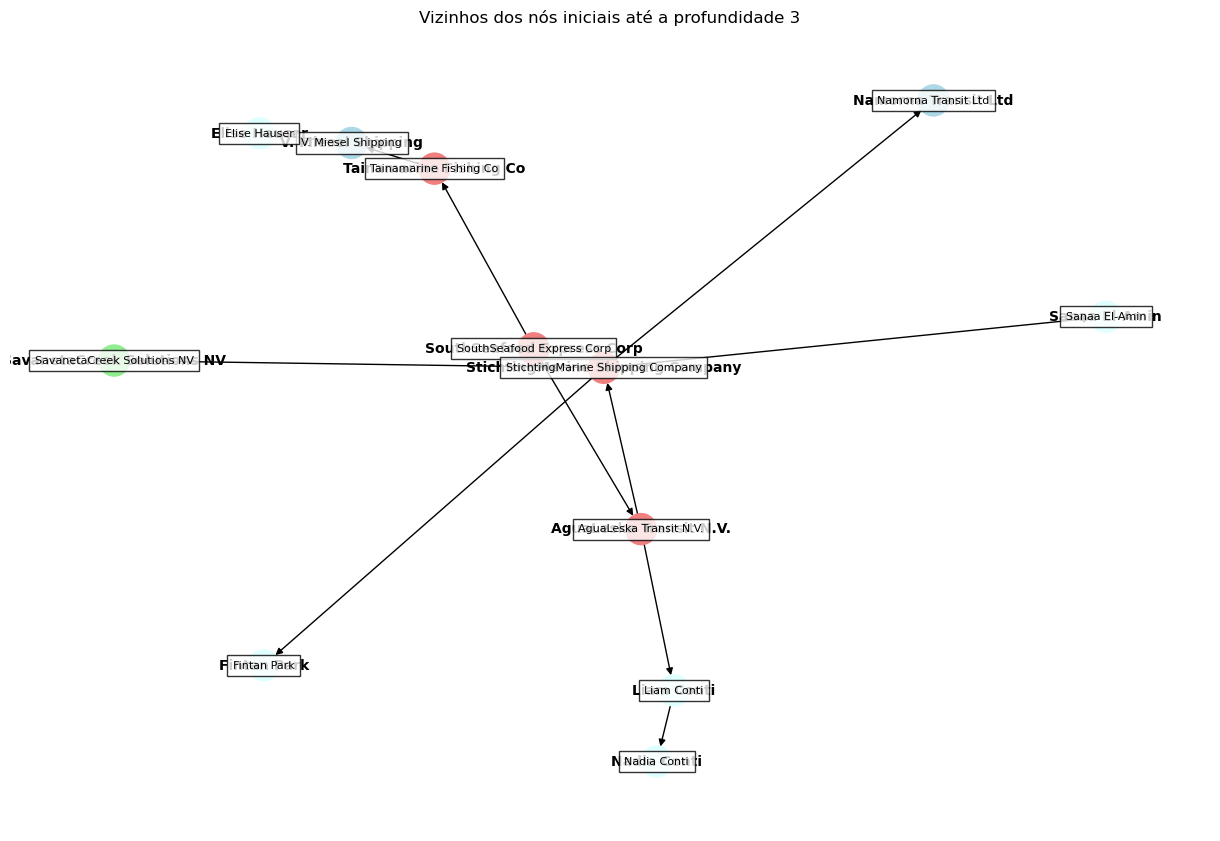

In [115]:

# Set the initial nodes
initial_nodes = ["May and Sons", "Jacobs PLC", "Conrad Ltd", "Vargas Ltd"]
initial_nodes = ["SouthSeafood Express Corp"]

depth = 3  # Define a profundidade desejada

# Create a subgraph by iteratively adding neighbors
subgraph = nx.DiGraph()

# Adicionando os nós iniciais ao subgrafo
for node in initial_nodes:
    node_type = next((n['type'] for n in data['nodes'] if n['id'] == node), None)
    subgraph.add_node(node, type=node_type)

# Explorando vizinhos até a profundidade especificada
nodes_to_explore = [(node, 0) for node in initial_nodes]

while nodes_to_explore:
    node, node_depth = nodes_to_explore.pop(0)  # Obter o próximo nó para explorar
    if node_depth < depth:
        neighbors = list(G.neighbors(node)) + list(G.predecessors(node))  # Obter vizinhos e predecessores
        for neighbor in neighbors:
            if neighbor not in subgraph.nodes:
                node_type = next((n['type'] for n in data['nodes'] if n['id'] == neighbor), None)
                subgraph.add_node(neighbor, type=node_type)  # Adicionar nó com seu tipo
                subgraph.add_edge(node, neighbor)
                nodes_to_explore.append((neighbor, node_depth + 1))

# Mapeamento de cores com base no tipo de nó
color_mapping = {
    'Entity.Organization.Company': 'lightblue',
    'Entity.Organization.LogisticsCompany': 'lightgreen',
    'Entity.Organization.FishingCompany': 'lightcoral',
    'Entity.Organization.FinancialCompany': 'lightyellow',
    'Entity.Organization.NewsCompany': 'lightpink',
    'Entity.Organization.NGO': 'lightgrey',
    'Entity.Person': 'lightcyan',
    'Entity.Person.CEO': 'lightorange'
}

# Desenhar o subgrafo com cores de nós com base no tipo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)  # Layout para os nós
node_colors = [color_mapping[subgraph.nodes[node]['type']] for node in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_weight='bold')

# Adicionar tooltips para cada nó
tooltips = {node: f"{node}: {next((n for n in data['nodes'] if n['id'] == node), None)}" for node in subgraph.nodes}

# Adicionar tooltips
for node, (x, y) in pos.items():
    plt.text(x, y, node, bbox=dict(facecolor='white', alpha=0.8), fontsize=8, ha='center', va='center')

plt.title(f"Vizinhos dos nós iniciais até a profundidade {depth}")
plt.show()

In [124]:
G = nx.node_link_graph(data)

# Lista de nós para verificar conexão com "SouthSeafood Express Corp"
nodes_to_check = ["May and Sons", "Jacobs PLC", "Conrad Ltd", "Vargas Ltd", "Raymond LLC",
"Carlson-Wang",
"Johnson-Gonzalez",
"Harding LLC",
"Morse Group",
"Barrett, Morales and Gonzalez",
"Cortez LLC",
"Cook-Terry",
"Wade-Lynn",
"Cooper Inc",
"Patrick, Mcneil and Williams",
"Espinoza-Jackson",
"Mcdaniel PLC",
"Garrett, Williams and Willis",
"Harper, Brennan and Taylor",
"Gutierrez-Bell",
"Liu-Dawson",
"Herrera, Smith and Gallagher",
"Levy-Stanley",
"Huffman Ltd",
"Stevens, Hoffman and French",
"Perez-Munoz",
"Thomas, Richardson and Wade",
"Schmidt, Evans and Chase",
"Taylor-Miller",
"Scott Inc",
"Terry-Allen"]

# Verificar conexão com "SouthSeafood Express Corp"
for node in nodes_to_check:
    if nx.has_path(G, node, "SouthSeafood Express Corp"):
        print(f"{node} está conectado com SouthSeafood Express Corp.")

# Beneficiarios

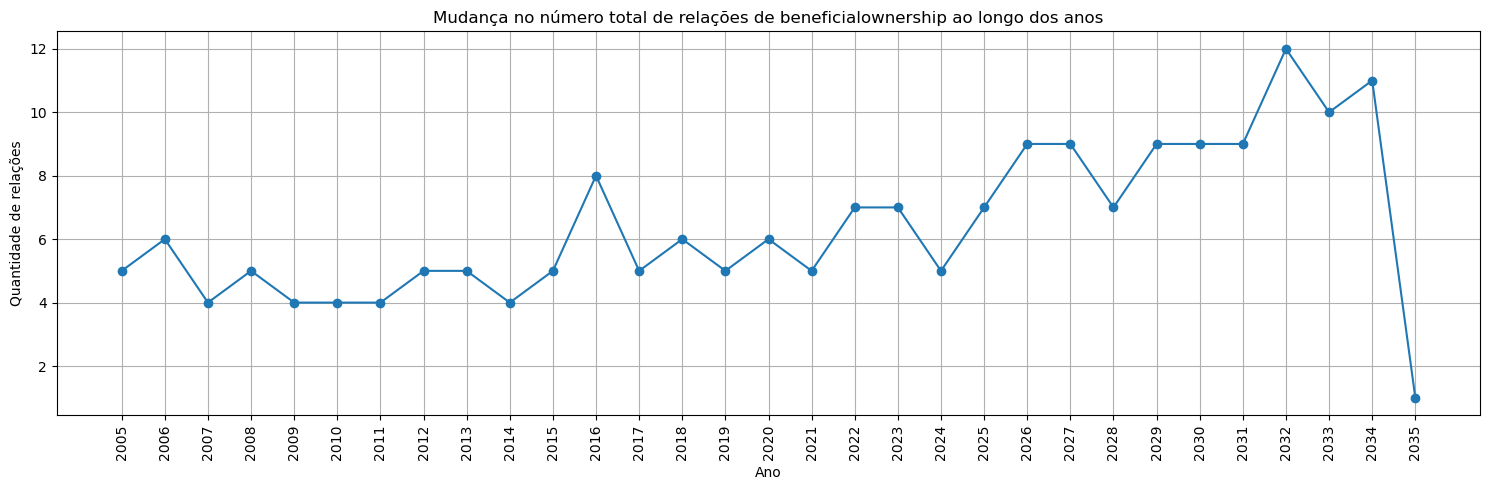

In [32]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_beneficialownership_year['start_date'], max_beneficialownership_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_beneficialownership_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
max_beneficialownership_year['count'].mean()

6.387096774193548

#  Number Works

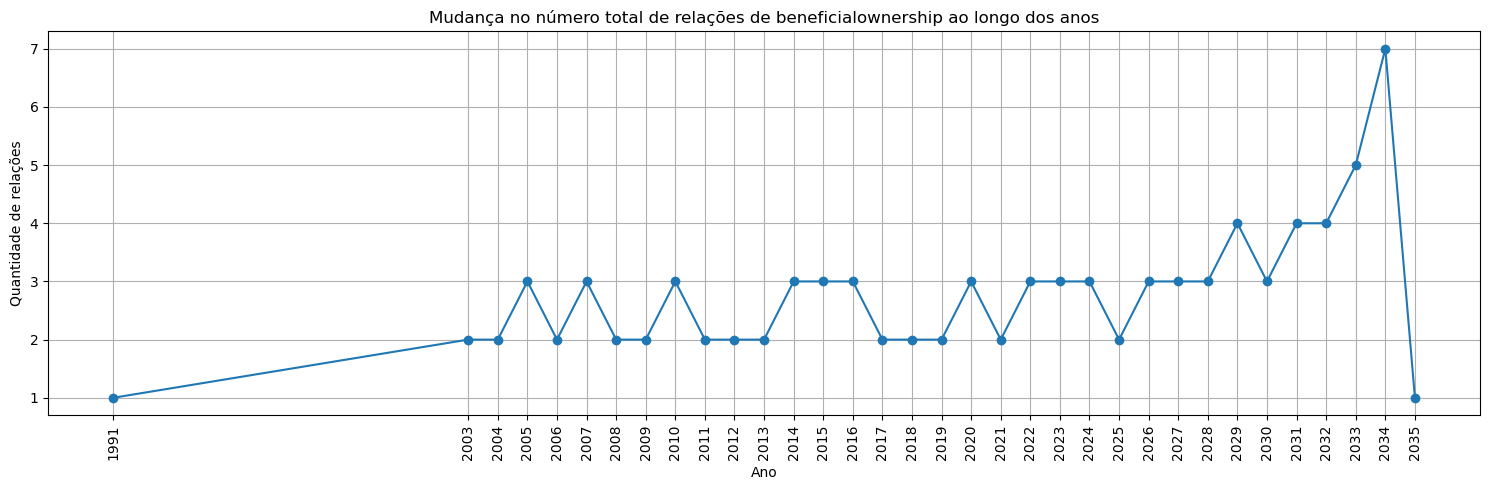

In [33]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_count_worksfor_year['start_date'], max_count_worksfor_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_count_worksfor_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(years, familyrelationship_counts, marker='o', linestyle='-', color='purple', label='Family Relationship')
plt.title('Quantidade de Family Relationship ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Relações')
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'years' is not defined

<Figure size 1200x600 with 0 Axes>

* Event.Owns.Shareholdership (Propriedade/Acionistas):

Esta relação indica que uma entidade (por exemplo, uma empresa) possui participação acionária em outra entidade. É útil para entender a estrutura de propriedade e as conexões acionárias entre empresas.

* Event.Owns.BeneficialOwnership (Propriedade Beneficiária):

Este tipo de relação se refere à propriedade beneficiária, que é diferente da propriedade legal direta. Indica que uma entidade possui benefício econômico de uma propriedade, mesmo que não seja o proprietário legal registrado. É comumente usado para identificar quem realmente se beneficia das ações ou propriedades de uma empresa, especialmente em estruturas complexas de propriedade.

* Event.WorksFor (Trabalha Para):

Esta relação indica que uma pessoa ou entidade trabalha para outra. Por exemplo, um funcionário trabalha para uma empresa. É útil para entender a estrutura organizacional e as relações de emprego dentro das entidades.

* Relationship.FamilyRelationship (Relacionamento Familiar):

Este tipo de relação indica um relacionamento familiar entre entidades. Pode ser usado para identificar conexões familiares dentro de empresas ou entre entidades, o que pode influenciar decisões empresariais e estratégias.